In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

import urllib.request as request


In [35]:
class Config:
    def __init__(self):
        self.ROOT_DATA_DIR="hymenoptera_data"
        self.EPOCH=20
        self.BATCH_SIZE=32
        self.LEARNING_RATE=0.01
        self.IMAGE_SIZE=(224,224)
        self.DEVICE="cuda" if torch.cuda.is_available() else "cpu"
        print(f"This notebook is using device: {self.DEVICE}")
        self.SEED=42
    def create_dir(self,dir_path):
        os.makedirs(dir_path, exist_ok=True)
        print(f"{dir_path} directory is created")
config=Config()

This notebook is using device: cpu


# Download Data

In [41]:
data_URL="https://download.pytorch.org/tutorial/hymenoptera_data.zip"

In [42]:
config.create_dir(dir_path=config.ROOT_DATA_DIR)

hymenoptera_data directory is created


In [43]:
data_zip_file="data.zip"
data_file_path=os.path.join(config.ROOT_DATA_DIR,data_zip_file)
request.urlretrieve(data_URL, data_file_path)


('hymenoptera_data\\data.zip', <http.client.HTTPMessage at 0x15b14cb7848>)

In [44]:
from zipfile import ZipFile
def unzip_file(source: str, dest:str) -> None:
    print(f"extraction started.......")
    with ZipFile(source, "r") as zip_f:
        zip_f.extractall(dest)
    print(f"extracted {source} to {dest}")

In [45]:
unzip_file(data_file_path, config.ROOT_DATA_DIR)

extraction started.......
extracted hymenoptera_data\data.zip to hymenoptera_data


In [46]:
!ls hymenoptera_data/hymenoptera_data/train

ants
bees


In [47]:
Path("hymenoptera_data/hymenoptera_data/train")

WindowsPath('hymenoptera_data/hymenoptera_data/train')

In [48]:
from pathlib import Path

In [49]:
train_path=Path("hymenoptera_data/hymenoptera_data/train")
test_path=Path("hymenoptera_data/hymenoptera_data/val")

# mean of the each channel of the image
#### for 28,28 img size
1.  mean=sum(value of the pixels)/784
2. std=(data-mean(/std

In [50]:
mean=torch.tensor([0.5,0.5,0.5])
std=torch.tensor([0.5,0.5,0.5])

In [51]:
train_transforms=transforms.Compose([
    transforms.Resize(config.IMAGE_SIZE),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    
])
test_transforms=transforms.Compose([
    transforms.Resize(config.IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    
])

In [52]:
train_data=datasets.ImageFolder(root=train_path, transform=train_transforms)
test_data=datasets.ImageFolder(root=train_path, transform=test_transforms)

In [53]:
train_data.class_to_idx

{'ants': 0, 'bees': 1}

In [54]:
label_map=train_data.class_to_idx
label_map

{'ants': 0, 'bees': 1}

In [55]:
train_data

Dataset ImageFolder
    Number of datapoints: 244
    Root location: hymenoptera_data\hymenoptera_data\train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=tensor([0.5000, 0.5000, 0.5000]), std=tensor([0.5000, 0.5000, 0.5000]))
           )

In [56]:
test_data

Dataset ImageFolder
    Number of datapoints: 244
    Root location: hymenoptera_data\hymenoptera_data\train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=tensor([0.5000, 0.5000, 0.5000]), std=tensor([0.5000, 0.5000, 0.5000]))
           )

# Create data loader

In [57]:
train_loader=DataLoader(train_data, shuffle=True, batch_size=config.BATCH_SIZE)
test_data=DataLoader(test_data, shuffle=False, batch_size=config.BATCH_SIZE)

In [58]:
data=next(iter(train_loader))

In [59]:
len(data)

2

In [60]:
images, labels=data

In [61]:
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

# Visualize one of the Samples

In [62]:
img=images[0]
img.shape

torch.Size([3, 224, 224])

TypeError: Invalid shape (3, 224, 224) for image data

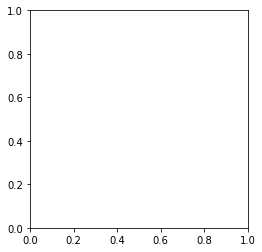

In [63]:
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


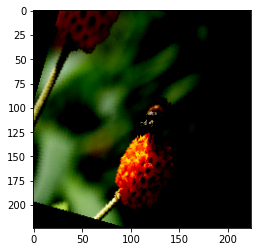

In [65]:
plt.imshow(img.permute(1,2,0))# permute->exchange first index with last index----output will be->[224,224,3]

In [66]:
models.AlexNet

torchvision.models.alexnet.AlexNet